# Homework 07: Ensemble Methods – Gradient Boosting

## Due: Midnight on June 30 (with 2-hour grace period) and worth 50 points

Over the past two weeks, we have expanded our machine learning toolkit by moving beyond linear regression to explore decision trees, which require finding optimal settings for a large set of interacting parameters. Through Homework 6, you developed a systematic workflow for parameter tuning that balances manual exploration and automated searches (e.g., grid search) to optimize performance while gaining insights into model behavior.

This week, we take another step forward by studying ensemble methods which combine multiple decision trees to produce even stronger predictive models. Specifically, we will investigate **Gradient Boosting,** currently the SOTA among non-deep learning methods.   


### What We Will Do in This Homework

To analyze and optimize our ensemble models, we will apply the two-phase strategy introduced in Homework 6. However, we will **add two new tools** to our toolbox for tuning models:

- We will employ **randomized grid search before exhaustive grid search** to efficiently explore the hyperparameter space and identify promising regions without the high computational cost of evaluating every possible combination.
- You will **store your best parameter values (and the resulting CV MAE) in a dictionary** in order to track improvements across experiments and maintain a clear record of how each parameter choice was made.  This is essential when doing manual tuning. 

Our two-phase strategy is thus (with the new features in italics):
1. **First Phase:**  
   - Iteratively sweep through key parameters in **coarse ranges**, *keeping track of results in a dictionary*  
   - Visualize training, validation, and test MAE  
   - Diagnose overfitting or underfitting  
   - Repeat the iterative sweep with a finer granularity for each parameter (for example, for `n_estimators` you might start with 100, 150,  etc. for the first set of sweeps, then try 125, 150,  ...)

2. **Second Phase:**  
   - Focus on the most unstable or promising parameter ranges found in Phase 1  
   - *Perform a random search within these narrower ranges using `RandomizedSearch`* 
   - Perform an exhaustive grid search within an even narrower range using `GridSearchCV` with the finest appropriate granularity (e.g., for `n_estimators` it might be 800, 801, 802, ..., 849, 850)

We will follow this process for Gradient Boosting Regressor, systematically tuning the most important parameters (see **Appendix 1** for a complete list):
 
> `n_estimators`, `max_depth`, `max_features`, `min_samples_split`, `min_samples_leaf` 

**Note that we will NOT be tuning the learning rate.**  

>Gradient Boosting Trees can appear to improve endlessly as you add more and more estimators (and decrease the learning rate correspondingly), however, there is a serious risk of **overfitting**.  There are various ways of controlling this, for example, using Early Stopping, or by keep track of the standard deviation of the CV scores, or by comparing with the test scores, but for the purposes of this homework, we will control overfitting in a naive way by keeping the learning rate fixed at its default value and tuning the other parameters. The point is to focus on the workflow of manual and automated parameter tuning. 

We will continue using `RepeatedKFold` cross-validation to reduce variance in our CV MAE estimates. The default number of repetitions is 5, but you may find it necessary to reduce this when initially searching broad parameter spaces—then increase it for fine-tuning as you zero-in on the best models. 



### Before Starting
- Review lesson materials on ensemble methods and pay special attention to the Gradient Boosting video and notebook, as the code in this homework builds on (and has been adapted from) those resources.
- Refer to **Appendix 2** for more complete advice about tuning strategies, and **Appendix 3** for an explanation of randomized grid search in Keras and a comparison with exhaustive search.  
  

### Grading

This homework consists of 5 graded problems, each worth 10 points, for a total of 50 points.

In [1]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time

from scipy.stats import uniform, randint

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble        import GradientBoostingRegressor
from sklearn.metrics         import mean_absolute_error
from tqdm                    import tqdm

import matplotlib.ticker as mticker           # Optional: you can print out y axis labels as dollars. 

# globals

random_seed = 42

# utility code

# Optional:  Format y-axis labels as dollars with commas
def dollar_format(x, pos):
    return f'${x:,.0f}'

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

C:\Users\abcbb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Ames Housing Dataset  

The code cell below will load the dataset for you.  This is the same dataset we used for the last two homeworks. 

> **Notice** that this code includes a useful optimization: **before downloading, it first
checks whether the files already exist.** This is a essential step when working with large datasets or when building deep learning models, where training can span hours or even days. By reusing previously downloaded files or saved models, you can avoid unnecessary work and significantly speed up your workflow.

For a detailed description of the dataset features, please refer to the **Appendix** in Homework 05. 

In [2]:
data_dir = "Ames_Dataset"                              # Directory where files will be stored

# Check if one of the files exists; if not, download and extract the zip file

if not os.path.exists( os.path.join(data_dir, "X_train.csv") ):
    print("Dataset files not found. Downloading...")
    zip_url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/ames_housing.zip"
    try:
        response = requests.get(zip_url)
        response.raise_for_status()  # Raise an error for bad status codes
        # Extract the zip file into the designated directory
        with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
            zipf.extractall(data_dir)
        print("Files downloaded and extracted successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("Dataset files already exist. Skipping download.")

# Load the datasets
X_train = pd.read_csv(os.path.join(data_dir, "X_train.csv"))
X_test  = pd.read_csv(os.path.join(data_dir, "X_test.csv"))
y_train = pd.read_csv(os.path.join(data_dir, "y_train.csv")).squeeze("columns")    
y_test  = pd.read_csv(os.path.join(data_dir, "y_test.csv")).squeeze("columns")

print("Training and testing datasets loaded successfully.")


Dataset files already exist. Skipping download.
Training and testing datasets loaded successfully.


## Prelude: Wrapper Functions for Running Ensemble Models

The following cells are adapted from the Week 7 video notebook on `GradientBoostingRegressor`, but have been refactored to be more generally useful (perhaps in your final project):

- **`run_model`** replaces the original `run_gradient_boosting_regressor` and accepts a parameter dictionary that can be applied to any model. You do not need to call this explicitly in this homework. 
- **`sweep_parameter`** is updated to work seamlessly with `run_model`, letting you:
  - Specify which model you want to use;  
  - Pass a dictionary of model parameters; and  
  - Return a modified parameter dictionary reflecting the best value of the parameter you swept, along with the corresponding MAE.

**Note:** Please do not change these cells unless you consult with the LFs first. Any alterations may cause downstream issues with the assignment.

In [3]:
# Run the model for testing and returning metrics.
# NOTE: You can NOT use this for running the model on the test set.

def run_model(model, 
              X_train, y_train, 
              n_repeats=5, 
              n_jobs=-1, 
              **model_params
             ):

    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    # Use negative MAE for cross-validation (since sklearn minimizes loss)
    neg_mae_scores = cross_val_score(
        model, 
        X_train, y_train,
        scoring='neg_mean_absolute_error',
        cv=RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=random_seed), 
        n_jobs=n_jobs
    )
    
    mean_cv_mae = -np.mean(neg_mae_scores)
    std_cv_mae  =  np.std(neg_mae_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training MAE
    train_preds = model.predict(X_train)
    train_mae   = mean_absolute_error(y_train, train_preds)
    
    return mean_cv_mae, std_cv_mae, train_mae


In [4]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,              # Defined above
                    y_train          = y_train,
                    verbose          = True,
                    show_mae         = True,
                    show_std         = False,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 5
                   ):
    

    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_maes, std_cvs, train_maes = [], [], []
    no_improve_count = 0
    best_mae = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        P_temp.pop('MAE_found', None)  # Just in case
        
        cv_mae, std_cv, train_mae = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_maes.append(cv_mae)
        std_cvs.append(std_cv)
        train_maes.append(train_mae)
        
        if cv_mae < best_mae - delta:
            best_mae = cv_mae
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    # Identify best parameter
    min_cv_mae = min(cv_maes)
    min_index = cv_maes.index(min_cv_mae)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MAE_found'] = min_cv_mae

    # ---------- Plotting section ----------
    if verbose:
        partial_param_list = parameter_list[:len(cv_maes)]

        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list

        error_name = 'MAE'

        # Create appropriate number of subplots
        if show_std:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

        ax1.set_title(f"{error_name} vs {param}")
        if show_mae:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

        ax1.plot(x_vals,
                 cv_maes,
                 marker='.', label="CV MAE", color='blue')
        ax1.plot(x_vals,
                 train_maes,
                 marker='.', label="Train MAE", color='green')
        ax1.scatter([x_vals[min_index]],
                    [min_cv_mae],
                    marker='x', label="Best CV MAE", color='red')

        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()

        # Optional Std Dev Plot
        if show_std:
            ax2.set_title(f"CV Standard Deviation vs {param}")
            ax2.plot(x_vals, std_cvs, marker='.', label="CV MAE Std", color='blue')
            ax2.set_xlabel(param)
            ax2.set_ylabel("Standard Deviation")
            ax2.legend()
            ax2.grid(alpha=0.5)

            if is_boolean:
                ax2.set_xticks(x_vals)
                ax2.set_xticklabels(x_labels)
        else:
            ax1.set_xlabel(param)
            if is_boolean:
                ax1.set_xticks(x_vals)
                ax1.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))

    return Parameters



### Problem 1: Iterative Parameter Sweeping and Visualization with `sweep_parameter(...)`

In this problem, you’ll tune six key hyperparameters of `GradientBoostingRegressor` by manually sweeping their values and visualizing the results using **Mean Absolute Error (MAE)** as your evaluation metric. 


We’ll accelerate the tuning workflow introduced in Homework 6 by updating our estimate of the optimal parameter value after **each** sweep of an individual parameter.

For each sweep, `sweep_parameter(...)` will allow you to:

* **Test a range of values** for the selected parameter
* **Plot**:

  * Training MAE
  * Repeated cross-validation MAE

  These plots will help you diagnose **overfitting** or **underfitting**

* **Record the best value**—the one that yields the lowest mean CV MAE—in `Parameters_GB`

You’ll invoke it like this:

```python
Params_GB = sweep_parameter(GradientBoostingRegressor,   
                            Params_GB,   
                            ...
```
Begin by copying the provided `Default_Parameters_GB` dictionary to a new dictionary called `Parameters_GB`.


### Goal

Your objective is to apply a **coarse-to-fine tuning strategy**: begin with broad parameter ranges and coarse steps, then narrow the range and increase granularity as you approach a good model. This prepares you for later stages where **randomized** or **grid search** can be used to fine-tune.

For example, when sweeping `n_estimators`, you might proceed as follows:

* Start with `range(100, 1001, 100)`
* Narrow to `range(800, 1001, 50)`
* Refine further with `range(900, 1001, 25)` etc.

### Step-by-Step Sweeping Procedure

**Tip:** Use 5 repeats for `RepeatedKFold` scoring for stable CV estimates. For broad sweeps, you may reduce to 1–2 repeats to speed up experimentation, but be sure to restore to 5 before finalizing.



1. **Sweep `n_estimators`** (*integer values*):

   * Test a range of values (e.g., 200 ..., 1000)
   * Begin with a step size of 100
   * Plot results and update `Parameters_GB` with the value yielding the lowest mean CV MAE

2. **Sweep `max_depth`** (*integer values*):

   * Test tree depths such as 5, 10, ...
   * Use a step size of 5 initially
   * Plot results and store the best value in `Parameters_GB`

3. **Sweep `max_features`** (*integer values*):

   * Try integers such as 5, 10, 15...  ('sqrt' and 'log2' are possible, but integers are more precise)
   * Start with a step size of 5
   * Check `X_train.shape` to see the maximum number of features
   * Plot results and store the best value in `Parameters_GB`

4. **Sweep '`min_samples_split`** (*integer values*):

   * Test integers such as 2, 7, 13 ...
   * Use a step size of 5 initially
   * Plot results and store the best value in `Parameters_GB`

5. **Sweep `min_samples_leaf`** (*integer values*):

   * Try integers such as 1, 6, 11 ...  
   * Start with a step size of 5
   * Plot results and store the best value in `Parameters_GB`

6. **Repeat with Finer Granularity**
   After your first pass, repeat steps 1–5.  I generally repeat it once without changing the range, and then I try it with narrower ranges and smaller step sizes. You don't have to change each parameter each time through. Eventually, you want to end up with fairly narrow ranges with medium-sized steps:

   * `n_estimators`: step size of **10** or even **5**
   * For the others, a step size of **2** or even **1**

   Your goal is to home in on the optimal parameter region, using CV MAE  as guide.



6. **Ensure Robustness**

   * Your final sweep should use **at least 5 repeats** for `RepeatedKFold`
   * This final configuration will form the foundation for Problem 2


### Final Reporting

After completing 2 - 5 rounds of parameter sweeping:

* Report the final tuned values stored in `Parameters_GB`
* Display the final **MAE** clearly, in **dollars**
* Respond to the associated **graded question**


In [5]:
Default_Parameters_GB = {
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'min_samples_split'       : 2,               # Defines the minimum number of samples required to split an internal node.
    'min_samples_leaf'        : 1,               # Specifies the minimum number of samples that must be present in a leaf node. 
    'random_state'            : random_seed,     # Controls randomness of boosting. Useful for reproducibility.
    'MAE_found'               : float('inf')     # NOT a model parameter, but will record the MAE found for the current parameter choices
}


In [6]:
# Make a copy of the default dictionary

Params_GB = Default_Parameters_GB.copy()



--- Round 1: Coarse Sweep (n_repeats=2) ---


Sweeping n_estimators: 100%|██████████| 9/9 [01:21<00:00,  9.04s/it]


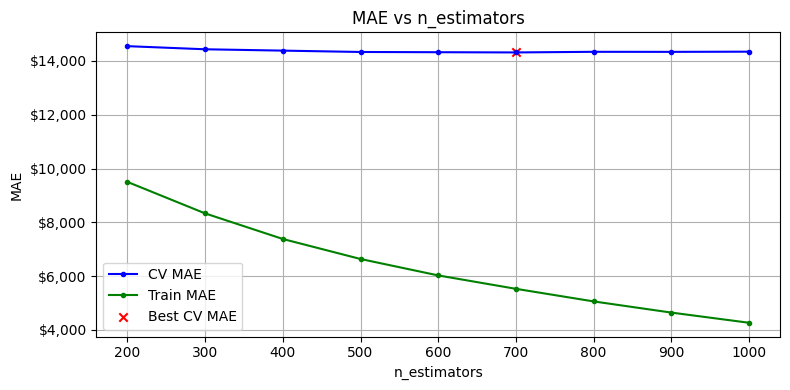

Execution Time: 00:01:21


Sweeping max_depth: 100%|██████████| 4/4 [01:20<00:00, 20.01s/it]


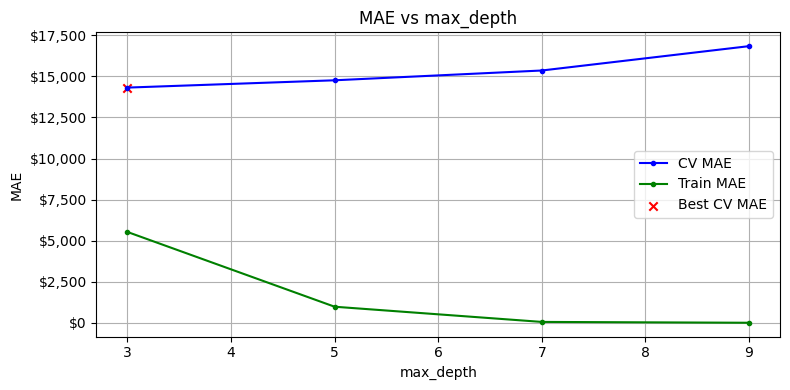

Execution Time: 00:01:20


Sweeping max_features: 100%|██████████| 9/9 [00:40<00:00,  4.51s/it]


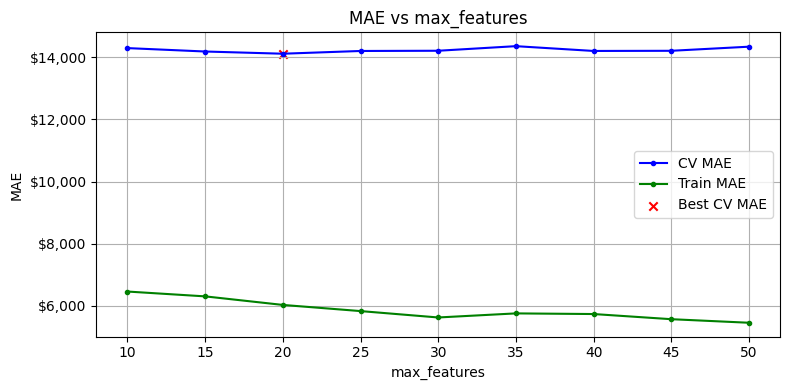

Execution Time: 00:00:40


Sweeping min_samples_split: 100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


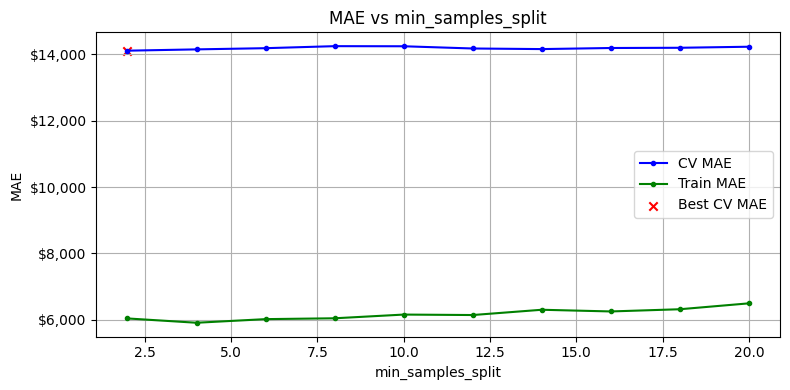

Execution Time: 00:00:32


Sweeping min_samples_leaf: 100%|██████████| 8/8 [00:25<00:00,  3.19s/it]


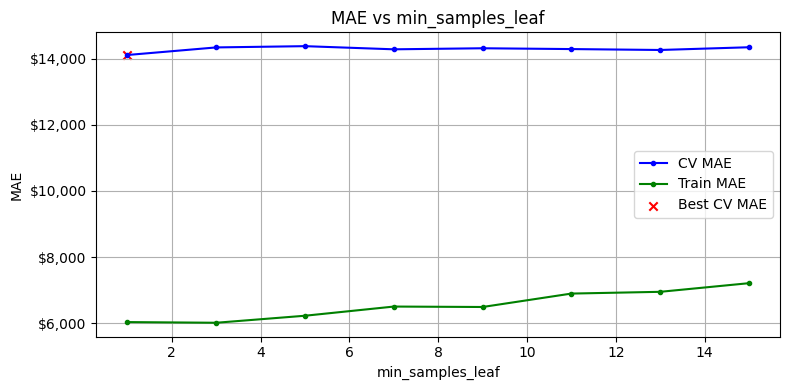

Execution Time: 00:00:25

--- Optimal parameters after Round 1 ---
{'n_estimators': 700, 'max_depth': 3, 'max_features': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': 14113.419625025355}


In [7]:
print("\n--- Round 1: Coarse Sweep (n_repeats=2) ---")

# 1. n_estimators: Determines the number of boosting stages (trees).
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'n_estimators', range(200, 1001, 100), n_repeats=2, verbose=True)

# 2. max_depth: Controls model complexity by limiting the depth of each tree.
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'max_depth', range(3, 10, 2), n_repeats=2, verbose=True)

# 3. max_features: Prevents overfitting by limiting the number of features for a split.
# Since X_train.shape[1] is 56, we will search up to 50.
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'max_features', range(10, 51, 5), n_repeats=2, verbose=True)

# 4. min_samples_split: Sets the minimum number of samples required to split a node.
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'min_samples_split', range(2, 21, 2), n_repeats=2, verbose=True)

# 5. min_samples_leaf: Sets the minimum number of samples required in a leaf node.
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'min_samples_leaf', range(1, 16, 2), n_repeats=2, verbose=True)

print("\n--- Optimal parameters after Round 1 ---")
print(Params_GB)


--- Round 2: Refined Sweep (n_repeats=3) ---


Sweeping n_estimators: 100%|██████████| 9/9 [00:30<00:00,  3.40s/it]


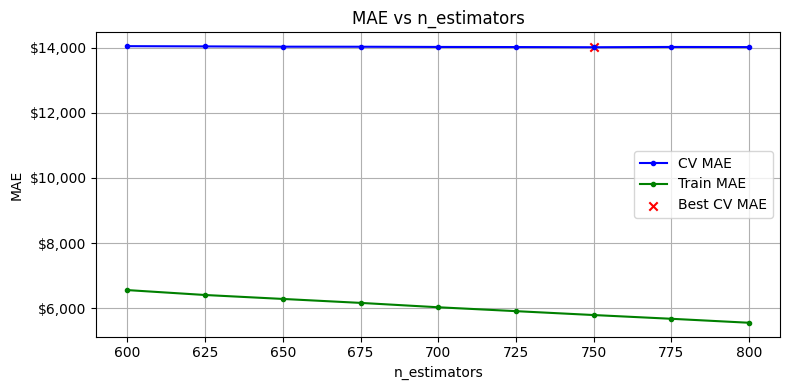

Execution Time: 00:00:30


Sweeping max_depth: 100%|██████████| 3/3 [00:14<00:00,  4.70s/it]


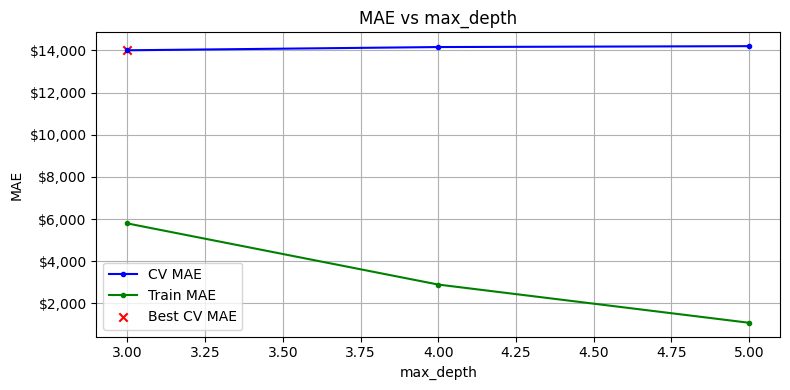

Execution Time: 00:00:14


Sweeping max_features: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


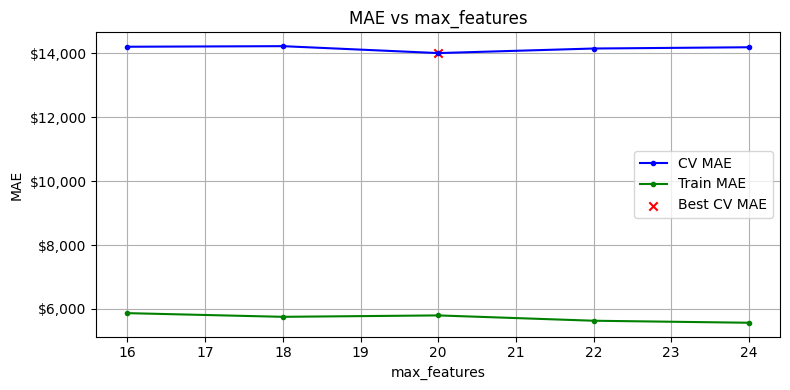

Execution Time: 00:00:18


Sweeping min_samples_split: 100%|██████████| 3/3 [00:10<00:00,  3.66s/it]


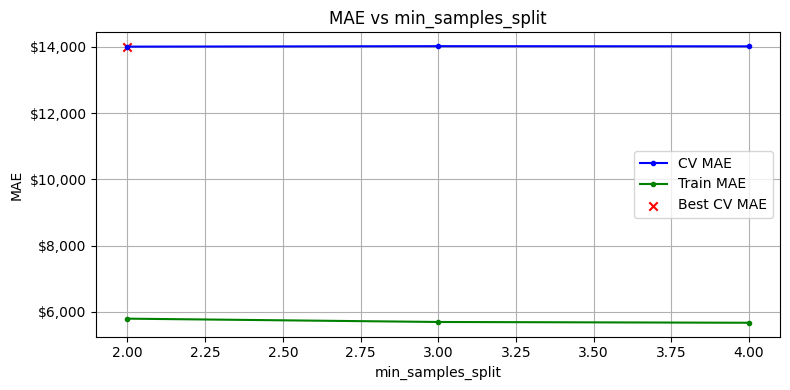

Execution Time: 00:00:11


Sweeping min_samples_leaf: 100%|██████████| 3/3 [00:11<00:00,  3.75s/it]


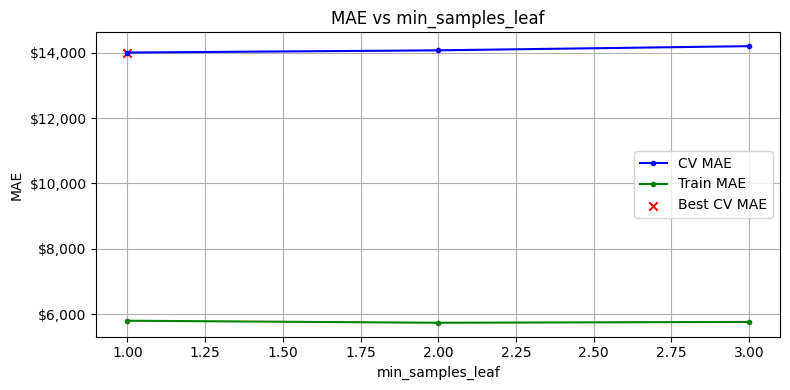

Execution Time: 00:00:11

--- Optimal parameters after Round 2 ---
{'n_estimators': 750, 'max_depth': 3, 'max_features': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': 14009.504784664305}


In [8]:
print("\n--- Round 2: Refined Sweep (n_repeats=3) ---")

# 1. n_estimators: Search around the best value from Round 1 with a smaller step (25).
best_n_estimators = Params_GB['n_estimators']
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'n_estimators', range(best_n_estimators - 100, best_n_estimators + 101, 25), n_repeats=3, verbose=True)

# 2. max_depth: Search with a finer step (1).
best_max_depth = Params_GB['max_depth']
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'max_depth', range(max(3, best_max_depth - 2), best_max_depth + 3, 1), n_repeats=3, verbose=True)

# 3. max_features: Search with a finer step (2).
best_max_features = Params_GB['max_features']
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'max_features', range(max(5, best_max_features - 4), best_max_features + 5, 2), n_repeats=3, verbose=True)

# 4. min_samples_split: Search with a finer step (1).
best_min_samples_split = Params_GB['min_samples_split']
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'min_samples_split', range(max(2, best_min_samples_split - 2), best_min_samples_split + 3, 1), n_repeats=3, verbose=True)

# 5. min_samples_leaf: Search with a finer step (1).
best_min_samples_leaf = Params_GB['min_samples_leaf']
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'min_samples_leaf', range(max(1, best_min_samples_leaf - 2), best_min_samples_leaf + 3, 1), n_repeats=3, verbose=True)

print("\n--- Optimal parameters after Round 2 ---")
print(Params_GB)


--- Round 3: Final Fine-Tuning Sweep (n_repeats=5) ---


Sweeping n_estimators: 100%|██████████| 11/11 [00:56<00:00,  5.13s/it]


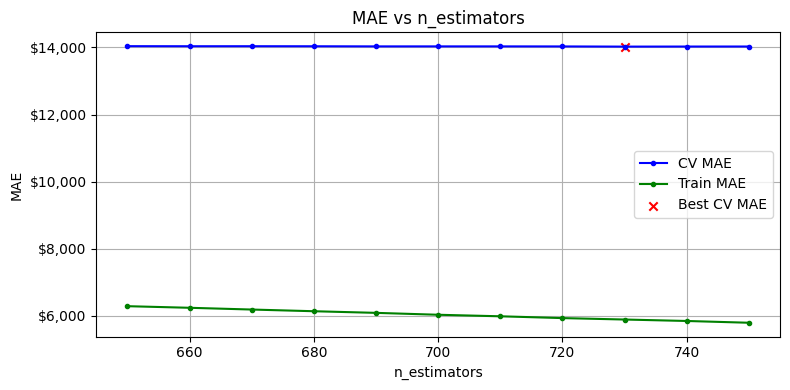

Execution Time: 00:00:56


Sweeping max_depth: 100%|██████████| 2/2 [00:11<00:00,  5.90s/it]


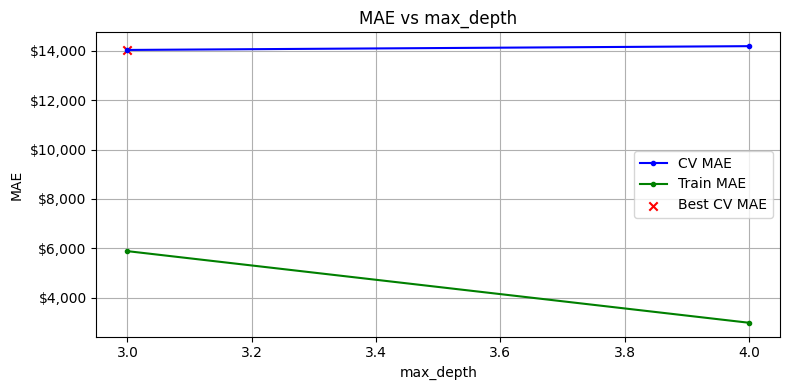

Execution Time: 00:00:11


Sweeping max_features: 100%|██████████| 5/5 [00:25<00:00,  5.14s/it]


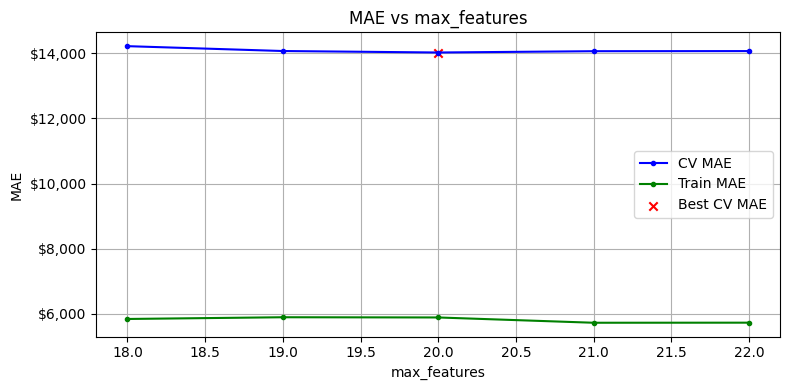

Execution Time: 00:00:25


Sweeping min_samples_split: 100%|██████████| 2/2 [00:10<00:00,  5.19s/it]


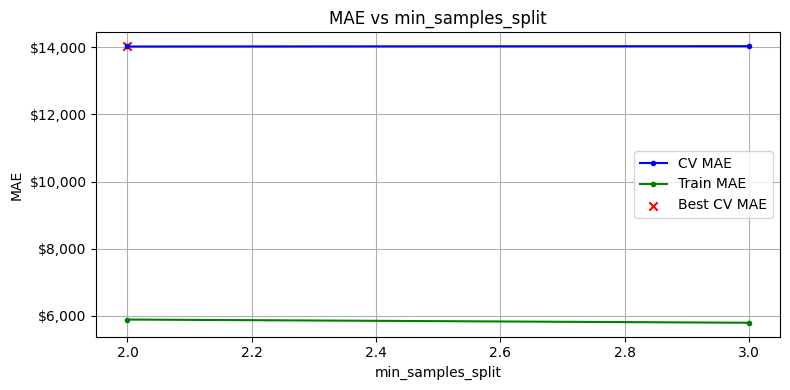

Execution Time: 00:00:10


Sweeping min_samples_leaf: 100%|██████████| 2/2 [00:10<00:00,  5.19s/it]


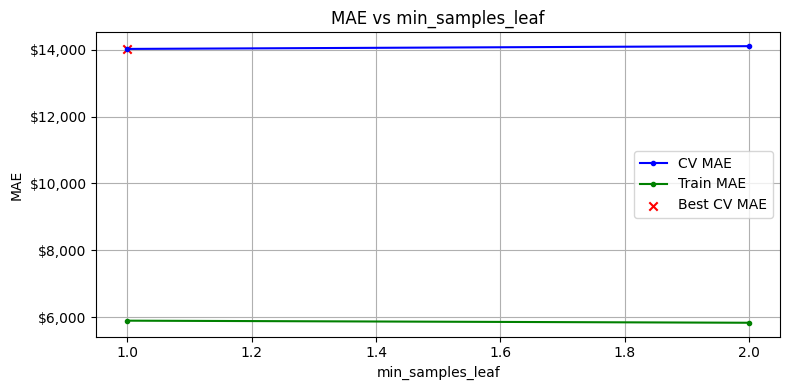

Execution Time: 00:00:10

--- Parameters after final tuning ---
{'n_estimators': 730, 'max_depth': 3, 'max_features': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42, 'MAE_found': 14024.433511186206}

Final CV MAE from manual parameter sweep: $14,024.43


In [8]:
print("\n--- Round 3: Final Fine-Tuning Sweep (n_repeats=5) ---")

# 1. n_estimators: Final search with a precise step (10).
best_n_estimators = Params_GB['n_estimators']
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'n_estimators', range(best_n_estimators - 50, best_n_estimators + 51, 10), n_repeats=5, verbose=True)

# 2. max_depth: Final confirmation with a step of 1.
best_max_depth = Params_GB['max_depth']
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'max_depth', range(max(3, best_max_depth - 1), best_max_depth + 2, 1), n_repeats=5, verbose=True)

# 3. max_features: Final confirmation with a step of 1.
best_max_features = Params_GB['max_features']
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'max_features', range(max(5, best_max_features - 2), best_max_features + 3, 1), n_repeats=5, verbose=True)

# 4. min_samples_split: Final confirmation with a step of 1.
best_min_samples_split = Params_GB['min_samples_split']
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'min_samples_split', range(max(2, best_min_samples_split - 1), best_min_samples_split + 2, 1), n_repeats=5, verbose=True)

# 5. min_samples_leaf: Final confirmation with a step of 1.
best_min_samples_leaf = Params_GB['min_samples_leaf']
Params_GB = sweep_parameter(GradientBoostingRegressor, Params_GB, 'min_samples_leaf', range(max(1, best_min_samples_leaf - 1), best_min_samples_leaf + 2, 1), n_repeats=5, verbose=True)

print("\n--- Parameters after final tuning ---")
print(Params_GB)

# Extract the final MAE from the dictionary.
final_mae = Params_GB.get('MAE_found', float('inf'))

print(f"\nFinal CV MAE from manual parameter sweep: ${final_mae:,.2f}")


### Problem 1 Graded Answer

Set `a1` to the CV MAE score of your best model. 

In [9]:
 # Your answer here

a1 = Params_GB['MAE_found']                     # replace 0 with your answer

In [10]:
# DO NOT change this cell in any way

print(f'a1 = ${a1:,.2f}')

a1 = $14,024.43


### Problem 2: Use `RandomizedSearch` to explore alternatives 
Once you have completed your parameter sweeps in Problem 2, you will explore the ranges you used in Problem 1 (or even narrower ranges) using randomized grid search (not grid search yet).  

Use the final ranges you used in Problem 1, or restrict them, but:
- Use `randint(lb,ub)` for all parameters (it will use to a granularity of 1)
- Do as many repetitions as you can without running it for hours. Try for at least 100.
- Be sure to use repeated CV scoring to be consistent with Problem 1.
- Print out the best result found by randomized search (including the final parameter choices) and answer the graded question.

**Note:** You may not get a better result than in Problem 1, but it is always worth trying randomized search!  

In [11]:
# Your code here -- Add as many code cells as necessary

print("\n--- Problem 2: Exploring with RandomizedSearchCV ---")

# Define the parameter distribution for randomized search
# This is based on the optimal values found in the manual sweep (Problem 1)
param_dist = {
    'n_estimators': randint(650, 851),        # Search integers from 650 to 850
    'max_depth': randint(3, 6),               # Search integers from 3 to 5
    'max_features': randint(15, 26),          # Search integers from 15 to 25
    'min_samples_split': randint(2, 6),       # Search integers from 2 to 5
    'min_samples_leaf': randint(1, 5)         # Search integers from 1 to 4
}

# Set up RandomizedSearchCV
# n_iter=100 means it will try 100 different random combinations
# cv uses RepeatedKFold for consistency, but with fewer repeats (n_repeats=3) to manage execution time
random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=random_seed),
    param_distributions=param_dist,
    n_iter=100,
    cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_seed),
    scoring='neg_mean_absolute_error',
    random_state=random_seed,
    n_jobs=-1,
    verbose=1  # Shows progress
)

# Fit the model
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

# Print the results
print(f"\nRandomized Search Execution Time: {format_hms(end_time - start_time)}")
print("\nBest parameters found by RandomizedSearch:")
print(random_search.best_params_)

# The best_score_ is negative MAE, so we multiply by -1 to get the positive MAE
best_mae_random = -random_search.best_score_
print(f"\nBest CV MAE from RandomizedSearch: ${best_mae_random:,.2f}")



--- Problem 2: Exploring with RandomizedSearchCV ---
Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Randomized Search Execution Time: 00:02:52

Best parameters found by RandomizedSearch:
{'max_depth': 3, 'max_features': 19, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 773}

Best CV MAE from RandomizedSearch: $14,082.81


### Problem 2 Graded Answer

Set `a2` to the best CV MAE score found using randomized search.

In [12]:
 # Your answer here

a2 = best_mae_random                     # replace 0 with your answer  

In [13]:
# DO NOT change this cell in any way

print(f'a2 = ${a2:,.2f}')

a2 = $14,082.81


### Problem 3: Confirmation: Use `GridSearchCV` for Exhaustive Search  

Now you have a pretty good idea of what the best parameter ranges are, and you have probed with randomized search to investigate the search space further. 
- Perform  **exhaustive grid searches** within appropriately restricted ranges using `GridSearchCV`. If possible, they should not be the same as you used for Problem 1, but even further restricted (so that it does not run for hours!). Use a granularity of 1 for all the parameters.
- **Print out the best result found by exhaustive search (including the final parameter choices** and answer the graded question.
 

In [19]:
# Your code here -- Add as many code cells as necessary

print("\n--- Problem 3: Final Confirmation with GridSearchCV (Corrected Code) ---")

# Define the parameter grid using np.arange for sequences.
param_grid_arange = {
    'n_estimators': np.arange(725, 736, 1),  # Generates [725, ..., 735]
    'max_depth': [3],                       # A single value is clearer as a list
    'max_features': np.arange(17, 22, 1),   # Generates [17, ..., 21]
    'min_samples_split': np.arange(2, 5, 1),    # Generates [2, 3, 4]
    'min_samples_leaf': np.arange(1, 4, 1)     # Generates [1, 2, 3]
}

# Calculate the number of combinations to be tested using numpy
# CORRECTED: Used the correct variable name 'param_grid_arange'
num_combinations = np.prod([len(v) for v in param_grid_arange.values()])
print(f"GridSearchCV will test {num_combinations} combinations.")


# Set up GridSearchCV
# We use n_repeats=5 for the most stable and final CV score.
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=random_seed),
    param_grid=param_grid_arange,  # CORRECTED: The argument name must be 'param_grid'
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_seed),
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1 # Shows progress
)

# Fit the model
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()


# Print the results
print(f"\nGrid Search Execution Time: {format_hms(end_time - start_time)}")
print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

# The best_score_ is negative MAE, so we multiply by -1
best_mae_grid = -grid_search.best_score_
print(f"\nBest CV MAE from GridSearchCV: ${best_mae_grid:,.2f}")



--- Problem 3: Final Confirmation with GridSearchCV (Corrected Code) ---
GridSearchCV will test 495 combinations.
Fitting 25 folds for each of 495 candidates, totalling 12375 fits

Grid Search Execution Time: 00:17:30

Best parameters found by GridSearchCV:
{'max_depth': 3, 'max_features': 21, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 725}

Best CV MAE from GridSearchCV: $13,979.56


### Problem 3 Graded Answer

Set `a3` to the best CV MAE score found using grid search.

In [20]:
 # Your answer here

a3 = best_mae_grid                     # replace 0 with your answer

In [21]:
# DO NOT change this cell in any way

print(f'a3 = ${a3:,.2f}')

a3 = $13,979.56


### Problem 4: Evaluate Your Models
At this point, you *may* have **three different models**:  
- The model found in **Problem 1** (from parameter sweeps).  
- The model found in **Problem 2** (from `RandomizedSearch`).
- The model found in **Problem 3** (from `GridSearchCV`).   

If you have done this correctly, grid search *should* have either confirmed your best model from Problem 1 or 2, or
found an even better model. 


### Problem 4 Graded Answer

Set `a4` to the number of the best model found:
- 1 = Problem 1 model, confirmed by Problem 3 model
- 2 = Problem 2 model, better than Problem 1, and confirmed by Problem 3
- 3 = Problem 3 model, better than Problem 1 or 2

In [22]:
 # Your answer here

a4 = 3                     # replace 0 with one of 1, 2, or 3

In [23]:
# DO NOT change this cell in any way

print(f'a4 = {a4}')

a4 = 3


### Problem 5: Report the Test Score of the Best Model  
Once you have selected the best model in Problem 4, report its **final test score** and answer the graded question.  

**Note:** You can not use `run_model` for this, as it is set up only for training runs. Create a gradient boosting model using the optimal parameters, fit it to the training set, and then generate predictions from the test set. 


In [24]:
# Your code here
print("\n--- Problem 5: Evaluating the Final Model on the Test Set ---")

# Step 1: Get the best parameters found by GridSearchCV in Problem 3.
# These parameters define our final, best model.
final_best_params = grid_search.best_params_
print("Final model parameters being used:")
print(final_best_params)

# Step 2: Create a new GradientBoostingRegressor model with these optimal parameters.
# The 'random_state' from the best_params_ ensures reproducibility.
final_model = GradientBoostingRegressor(**final_best_params)

# Step 3: Fit the final model on the ENTIRE training dataset.
print("\nTraining the final model on the full training data...")
final_model.fit(X_train, y_train)
print("Model training complete.")

# Step 4: Make predictions on the unseen test dataset.
test_predictions = final_model.predict(X_test)

# Step 5: Calculate the Mean Absolute Error on the test set.
# This score represents the model's true performance on new data.
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"\nFinal Test MAE of the best model: ${test_mae:,.2f}")


--- Problem 5: Evaluating the Final Model on the Test Set ---
Final model parameters being used:
{'max_depth': 3, 'max_features': 21, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 725}

Training the final model on the full training data...
Model training complete.

Final Test MAE of the best model: $14,414.98


### Problem 5 Graded Answer

Set `a5` to the test MAE of the model you selected in Problem 4.

In [25]:
 # Your answer here

a5 = test_mae                     # replace 0 with your answer

In [26]:
# DO NOT change this cell in any way

print(f'a5 = ${a5:,.2f}')

a5 = $14,414.98


## Appendix 1: Which `GradientBoostingRegressor` parameters are most important?

We will focus on the top **four** parameters in this list for `GradientBoostingRegressor`. 

---

**Most Important Parameters**

1. **learning_rate** (default: **0.1**)  
   *Controls the contribution of each individual tree. A lower learning rate generally requires more trees but can lead to improved generalization.*

2. **n_estimators** (default: **100**)  
   *Specifies the number of boosting stages (i.e., the number of trees in the ensemble). More estimators can improve performance but also increase the risk of overfitting if not tuned properly.*

3. **max_depth** (default: **3**)  
   *Limits the depth of the individual regression trees. Restricting the depth helps control overfitting and reduces the complexity of each base learner.*

4. **max_features** (default: **None**)  
   *Controls the number of features to consider when looking for the best split. Adjusting this can influence the bias-variance trade-off of the model.*

5. **min_samples_split** (default: **2**)  
   *Defines the minimum number of samples required to split an internal node. This parameter controls the growth of each tree and can prevent overly specific splits.*

6. **min_samples_leaf** (default: **1**)  
   *Specifies the minimum number of samples that must be present in a leaf node. This helps in ensuring that trees do not become too tailored to the training data.*

---

**Less Important Parameters**

7. **max_leaf_nodes** (default: **None**)  
    *An optional parameter that sets a maximum number of leaf nodes for each tree. This can provide an additional way to control the complexity of the model.*

8. **subsample** (default: **1.0**)  
   *Determines the fraction of samples used for fitting each individual tree. Values less than 1.0 introduce randomness into the boosting process, which can help reduce overfitting.*

9. **loss** (default: **'squared_error'**)  
   *Determines the loss function to be optimized during training. Different loss functions can be used depending on the specific characteristics of the regression problem.*





## Appendix 2: Tuning and Selecting Complex Models

This appendix offers practical guidance for tuning complex models like Gradient Boosting and for interpreting validation results to choose the best-performing configuration. It combines strategy, visualization, and decision-making heuristics into one workflow.



### 1. Using `sweep_parameters` for Single-Parameter Exploration

The function `sweep_parameters` automates parameter tuning by iterating over a range of values (e.g., `n_estimators`) and tracking performance across:

* **Training MAE**: Fit to training data
* **Cross-Validation (CV) MAE**: Generalization estimate across folds (and repeats)
* **Test MAE**: Out-of-sample check on a held-out test set

**How to Interpret the Plots:**

* **Training vs. CV MAE**: A growing gap often signals overfitting; high values for both may indicate underfitting.
* **CV MAE Curve**: Choose values near the minimum (valley), ideally where the curve flattens.
* **Watch Plot Scales**: A flat-looking curve may conceal meaningful differences if the y-axis scale is tight. Always consider actual values, not just shapes.



### 2. Tuning Strategy: Coarse-to-Fine

* Start with **broad ranges and coarse steps** (e.g., 100–1000 by 100).
* Once you find a promising region, **narrow the range and reduce step size** (e.g., 500–1000 by 25 or 10).


### 3. Using Repeated Cross-Validation Effectively

**Why Repeat?**
Repeated CV provides more stable estimates by averaging results across multiple random folds, reducing variance due to data splits.

**How Many Repeats?**

* **Early (Broad Sweeps):** 1–2 repeats for speed
* **Fine Tuning:** 5–10 repeats for stability and confidence in final selection

**Trade-Offs:**

* More repeats increase reliability, but also computation time. Scale up only after narrowing your search.


### 4. Model Selection: Key Indicators

When comparing models or parameter settings:

* **Minimize Mean CV MAE**: This is your primary signal of generalization performance during model tuning.

* **Look for Stability**: Favor flatter regions (plateaus) near the minimum of the CV MAE curve, rather than sharp dips that may reflect overfitting or noise.

* **Avoid Overfitting**: If you examine the test MAE **after tuning,** be cautious of a *growing gap* between CV MAE and test MAE.

  * This can suggest the model is fitting cross-validation folds too tightly.
  * However, do **not** use test MAE to guide parameter choices — reserve it as a **final check** only.

* **[Optional] Prioritize Consistency**: A lower standard deviation of CV scores indicates more stable performance across different splits.

* **Interpret Plots Carefully**: Always consider the **scale** of the y-axis when comparing curves. Flat-looking trends might conceal meaningful differences if the axis range is small.


### 5. Workflow Tips for Efficient Tuning

* **Visualize Everything**: Always plot training/CV/test MAE of CV scores for insight.
* **Track Experiments**: Use a dictionary (or a list of dictionaries) to record parameter settings and results.
* **Scale Up Thoughtfully**: Start simple and add complexity (more repeats, finer search) only when needed.
* **Use `GridSearchCV` and `RandomizedSearchCV` Judiciously**:

  * Start with random search to identify promising regions, then use grid search for final tuning.
  * Be aware that both methods may take significant time—especially without a progress bar.
* **Enable Parallelism with `n_jobs=-1`**: This will use all available CPU cores.

  * If you see warnings (e.g., “a worker stopped”), you may be running out of memory. Reduce `n_jobs` (e.g., to 4) if needed.



By combining thoughtful parameter sweeps, smart use of repeated CV, and careful reading of validation curves and variance, you’ll build models that not only perform well but generalize reliably.


## Appendix 3: Randomized Search vs. Grid Search for Gradient Boosting

This appendix compares two strategies for hyperparameter tuning—**randomized search** and **grid search**—using `GradientBoostingRegressor` as the working example. 

### 1. Problem Setup

Suppose you are training a `GradientBoostingRegressor` and want to optimize its predictive performance by tuning the key hyperparameters above.

```python
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=random_seed)
```



### 2. Grid Search

**Grid search** evaluates **all** combinations of parameter values in a predefined grid.

#### Define Parameter Grid

```python
param_grid = {

    'n_estimators'      : range(1000,1501,100),
    'max_depth'         : range(5,51,5),
    'max_features'      : [3, 4, 5],
    'min_samples_split' : [2,4,6,8],             
    'min_samples_leaf'  : [1,2,3],   
}
```

#### Run `GridSearchCV`

```python
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=param_grid,
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=42), 
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
```

* **Pros**: Exhaustive—guarantees best settings *within* your grid
* **Cons**: Combinatorial explosion—3×3×3×2 = 54 fits! Time and resources grow rapidly



### 3. Randomized Search

**Randomized search** samples a fixed number of combinations from **distributions** over the parameter space.

#### Define Distributions

This is a significant difference with grid search: you must specify a random-number generator instead of
giving a list of explicit values. 

```python
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators'      : randint(100, 500),        # integers from 100 to 499
    'max_depth'         : randint(3, 8),            # integers from 3 to 7
    'max_features'      : randint(2, 15),            
    'min_samples_split' : randint(2, 10),             
    'min_samples_leaf'  : randint(1, 8),             
}
```

#### Run `RandomizedSearchCV`

```python
from sklearn.model_selection import RandomizedSearchCV

rand = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,                 # try 20 random combinations
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_seed), 
    scoring='neg_mean_absolute_error',
    random_state=random_seed,
    n_jobs=-1
)
rand.fit(X_train, y_train)
print("Best parameters:", rand.best_params_)
```

* **Pros**: Efficient—fixed number of combinations regardless of parameter count
* **Cons**: May miss the absolute best—but often finds near-optimal solutions much faster



### 4. When to Use Which?

| Scenario          | Use Grid Search                 | Use Randomized Search               |
| ----------------- | ------------------------------- | ----------------------------------- |
| Search space size | Small, well-defined             | Large or continuous                 |
| Compute budget    | High                            | Moderate or limited                 |
| Goal              | Exhaustive search within a grid | Fast discovery of promising regions |
| Parameter types   | Discrete                        | Continuous or mixed                 |
| Tuning stage      | Final fine-tuning               | Early-stage exploration             |



### 5. Best Practices

1. **Start with Randomized Search**

   * Identify promising parameter ranges quickly and cheaply.

2. **Refine with Grid Search**

   * Use a tighter grid centered around the best values from the randomized search.

3. **Use Log Scale for Learning Rates**

   * For scale-sensitive values like `learning_rate`, sample from log-distributions (e.g., `loguniform(1e-3, 1e0)`).

4. **Validate on a Held-Out Test Set**

   * After tuning, always check your model’s performance on a separate test set to assess generalization.


